In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Dependencies
import pytz
import datetime as dt
from datetime import datetime
import dateparser
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from pprint import pprint 
from scipy.stats import linregress
import scipy.stats as stats
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from suntime import Sun, SunTimeException
import os
import json
import urllib.request

In [4]:
accident_data_to_load ="../Resources/US_Accidents_May19.csv"
accidents_data_df = pd.read_csv(
    accident_data_to_load)

# Visualize
accidents_data_df = accidents_data_df.reset_index()
accidents_data_df.set_index('ID', inplace=True)
accidents_data_df.head()


,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,29.68,10.0,Calm,NaN,0.02,Light Rain,False,Night,Night,Night
A-2,1,OH,2,2/8/16 6:07,2/8/16 6:37,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,...,29.65,10.0,Calm,NaN,0.00,Light Rain,False,Night,Night,Day
A-3,2,OH,2,2/8/16 6:49,2/8/16 7:19,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,...,29.67,10.0,SW,3.5,NaN,Overcast,True,Night,Night,Day
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day
A-5,4,OH,2,2/8/16 7:39,2/8/16 8:09,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,...,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,True,Day,Day,Day


In [5]:
#Taking only the interstates
accidents_data_df['hwy'] = accidents_data_df['Street'].str.split("-", n = 1, expand = True)[0].str.contains("I")== True
accidents_data_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,10.0,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True
A-2,1,OH,2,2/8/16 6:07,2/8/16 6:37,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,...,10.0,Calm,NaN,0.00,Light Rain,False,Night,Night,Day,False
A-3,2,OH,2,2/8/16 6:49,2/8/16 7:19,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,...,10.0,SW,3.5,NaN,Overcast,True,Night,Night,Day,False
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,9.0,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True
A-5,4,OH,2,2/8/16 7:39,2/8/16 8:09,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,...,6.0,SW,3.5,NaN,Mostly Cloudy,True,Day,Day,Day,False


In [6]:
interstate_df = accidents_data_df.loc[accidents_data_df['hwy'] == True]
interstate_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,10.0,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,9.0,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,3.0,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,True
A-27,26,OH,2,2/8/16 12:52,2/8/16 13:37,39.733219,-84.159653,0.00,Accident on Irving Ave at Wilmington Ave.,1240.0,...,7.0,West,9.2,0.00,Light Snow,True,Day,Day,Day,True
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,4.0,SW,11.5,NaN,Light Snow,False,Night,Night,Day,True


In [7]:
#Extract last letter of a string from a Pandas column to get the direction
interstate_df['Direction'] = interstate_df['Street'].str.strip().str[-1]
interstate_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True,E
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True,S
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,True,E
A-27,26,OH,2,2/8/16 12:52,2/8/16 13:37,39.733219,-84.159653,0.00,Accident on Irving Ave at Wilmington Ave.,1240.0,...,West,9.2,0.00,Light Snow,True,Day,Day,Day,True,e
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,True,S


In [8]:
interstate_df['hwy'] = interstate_df['Direction'].str.contains("E|W|N|S")== True
interstate_df.head()


,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True,E
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True,S
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,True,E
A-27,26,OH,2,2/8/16 12:52,2/8/16 13:37,39.733219,-84.159653,0.00,Accident on Irving Ave at Wilmington Ave.,1240.0,...,West,9.2,0.00,Light Snow,True,Day,Day,Day,False,e
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,True,S


In [9]:
hwy_df = interstate_df.loc[interstate_df['hwy'] == True]
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True,E
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True,S
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,True,E
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,True,S
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,WSW,9.2,0.00,Light Snow,False,Day,Day,Day,True,N


In [10]:
#converting the direction column to a list to check we get only teh valid direstions, N S E W
directionToList = hwy_df['Direction'].tolist()
#print(directionToList)

In [11]:
len(hwy_df)

209060

In [12]:
#extracting the accident date
hwy_df['Accident_Date'] = hwy_df['Start_Time'].str.split(" ", n = 1, expand = True)[0]
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction,Accident_Date
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,NaN,0.02,Light Rain,False,Night,Night,Night,True,E,2/8/16
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True,S,2/8/16
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,4.6,0.02,Light Rain,False,Day,Day,Day,True,E,2/8/16
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,11.5,NaN,Light Snow,False,Night,Night,Day,True,S,2/9/16
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,9.2,0.00,Light Snow,False,Day,Day,Day,True,N,2/9/16


In [13]:
#Converting date from string format to date format
hwy_df['Accident_Date'] = pd.to_datetime(hwy_df['Accident_Date'])
hwy_df['Accident_Date_No_Time'] = hwy_df['Accident_Date'].dt.date
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction,Accident_Date,Accident_Date_No_Time
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,0.02,Light Rain,False,Night,Night,Night,True,E,2016-02-08,2016-02-08
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,NaN,Mostly Cloudy,False,Night,Day,Day,True,S,2016-02-08,2016-02-08
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,0.02,Light Rain,False,Day,Day,Day,True,E,2016-02-08,2016-02-08
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,NaN,Light Snow,False,Night,Night,Day,True,S,2016-02-09,2016-02-09
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,0.00,Light Snow,False,Day,Day,Day,True,N,2016-02-09,2016-02-09


In [14]:
hwy_df = hwy_df.drop(['hwy', 'Accident_Date'], axis=1)

In [15]:
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date_No_Time
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,E,2016-02-08
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,S,2016-02-08
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,E,2016-02-08
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,S,2016-02-09
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,WSW,9.2,0.00,Light Snow,False,Day,Day,Day,N,2016-02-09


In [16]:
sunset_time = []
count = 0
for lat, lng, date in zip(hwy_df.loc[:, 'Start_Lat'], hwy_df.loc[:, 'Start_Lng'],hwy_df.loc[:, 'Accident_Date_No_Time']):
    #print(lat, lng, date)
    sun = Sun(lat, lng)
    sunset_time_pst = sun.get_local_sunset_time(date)
    #print(sunset_time)
    pst_dt = dateparser.parse(str(sunset_time_pst))
    utc_dt = pst_dt.astimezone(dt.timezone.utc)
    sunset_time_utc = utc_dt.strftime('%Y-%m-%d %H:%M')
    #print(sunset_time_utc) 
    sunset_time.append(sunset_time_utc)
    count+=1
    
print(count) 

209060


In [17]:
hwy_df = hwy_df.iloc[:count, :]
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date_No_Time
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,E,2016-02-08
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,S,2016-02-08
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,E,2016-02-08
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,S,2016-02-09
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,WSW,9.2,0.00,Light Snow,False,Day,Day,Day,N,2016-02-09


In [18]:
hwy_df['Sunset_Time_UTC'] = sunset_time

hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date_No_Time,Sunset_Time_UTC
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,NaN,0.02,Light Rain,False,Night,Night,Night,E,2016-02-08,2016-02-08 23:04
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,S,2016-02-08,2016-02-08 23:05
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,4.6,0.02,Light Rain,False,Day,Day,Day,E,2016-02-08,2016-02-08 22:59
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,11.5,NaN,Light Snow,False,Night,Night,Day,S,2016-02-09,2016-02-09 23:06
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,9.2,0.00,Light Snow,False,Day,Day,Day,N,2016-02-09,2016-02-09 23:06


In [19]:
hwy_df = hwy_df.rename({'Accident_Date_No_Time':'Accident_Date'}, axis=1)


In [20]:
hwy_df['Accident_Time'] = hwy_df['Start_Time'].str.split(" ", n = 1, expand = True)[1]
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,0.02,Light Rain,False,Night,Night,Night,E,2016-02-08,2016-02-08 23:04,5:46
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,NaN,Mostly Cloudy,False,Night,Day,Day,S,2016-02-08,2016-02-08 23:05,7:23
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,0.02,Light Rain,False,Day,Day,Day,E,2016-02-08,2016-02-08 22:59,8:21
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,NaN,Light Snow,False,Night,Night,Day,S,2016-02-09,2016-02-09 23:06,6:41
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,0.00,Light Snow,False,Day,Day,Day,N,2016-02-09,2016-02-09 23:06,8:23


In [21]:
#pytz.all_timezones

In [22]:
sunset_time_local = []

for date, time, timezone in zip(hwy_df.loc[:, 'Accident_Date'], hwy_df.loc[:, 'Sunset_Time_UTC'], hwy_df.loc[:, 'Timezone']):
    #print(timezone)  
    est = pytz.timezone('US/Eastern')
    pst = pytz.timezone('US/Pacific')
    mst = pytz.timezone('US/Mountain')
    cst = pytz.timezone('US/Central')
    ast = pytz.timezone('US/Alaska')
    hst = pytz.timezone('US/Hawaii')
    arst = pytz.timezone('US/Arizona')
    alst = pytz.timezone('US/Aleutian')
    eist = pytz.timezone('US/East-Indiana')
    isst = pytz.timezone('US/Indiana-Starke')
    mist = pytz.timezone('US/Michigan')
    sst = pytz.timezone('US/Samoa')
    utc = pytz.utc
    fmt = '%Y-%m-%d %H:%M'
    sunset_time_no_date = time.split(' ')[1]
    #print(sunset_time_no_date)
    utc_time = datetime(int(str(date).split('-')[0]), int(str(date).split('-')[1]), int(str(date).split('-')[2]), int(str(sunset_time_no_date).split(':')[0]), int(str(sunset_time_no_date).split(':')[1]), tzinfo=utc)
    
    #print(utc_time)
    if (timezone == 'US/Eastern'): 
        sunset_time_local.append(utc_time.astimezone(est).strftime(fmt))
    elif (timezone == 'US/Pacific'):        
        sunset_time_local.append(utc_time.astimezone(pst).strftime(fmt))
    elif (timezone == 'US/Mountain'):        
        sunset_time_local.append(utc_time.astimezone(mst).strftime(fmt))
    elif (timezone == 'US/Central'):        
        sunset_time_local.append(utc_time.astimezone(cst).strftime(fmt))
    elif (timezone == 'US/Alaska'):      
        sunset_time_local.append(utc_time.astimezone(ast).strftime(fmt))
    elif (timezone == 'US/Hawaii'):        
        sunset_time_local.append(utc_time.astimezone(hst).strftime(fmt))
    elif (timezone == 'US/Arizona'):        
        sunset_time_local.append(utc_time.astimezone(arst).strftime(fmt))
    elif (timezone == 'US/Aleutian'):        
        sunset_time_local.append(utc_time.astimezone(alst).strftime(fmt))
    elif (timezone == 'US/East-Indiana'):        
        sunset_time_local.append(utc_time.astimezone(eist).strftime(fmt))    
    elif (timezone == 'US/Indiana-Starke'):        
        sunset_time_local.append(utc_time.astimezone(isst).strftime(fmt))
    elif (timezone == 'US/Michigan'):        
        sunset_time_local.append(utc_time.astimezone(mist).strftime(fmt))
    elif (timezone == 'US/Samoa'):        
        sunset_time_local.append(utc_time.astimezone(sst).strftime(fmt))
   
    
#print(sunset_time_local)
    

In [23]:
len(sunset_time_local)

208993

In [24]:
hwy_df = hwy_df.iloc[:len(sunset_time_local), :]

In [25]:
hwy_df['Sunset_Date_Time_Local'] = sunset_time_local
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Light Rain,False,Night,Night,Night,E,2016-02-08,2016-02-08 23:04,5:46,2016-02-08 18:04
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,Mostly Cloudy,False,Night,Day,Day,S,2016-02-08,2016-02-08 23:05,7:23,2016-02-08 18:05
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,Light Rain,False,Day,Day,Day,E,2016-02-08,2016-02-08 22:59,8:21,2016-02-08 17:59
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,Light Snow,False,Night,Night,Day,S,2016-02-09,2016-02-09 23:06,6:41,2016-02-09 18:06
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,Light Snow,False,Day,Day,Day,N,2016-02-09,2016-02-09 23:06,8:23,2016-02-09 18:06


In [26]:
hwy_df['Sunset_Time_Local'] = hwy_df['Sunset_Date_Time_Local'].str.split(' ', n = 1, expand = True)[1]


In [27]:
hwy_sunset_df = hwy_df.copy()
hwy_sunset_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,False,Night,Night,Night,E,2016-02-08,2016-02-08 23:04,5:46,2016-02-08 18:04,18:04
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,False,Night,Day,Day,S,2016-02-08,2016-02-08 23:05,7:23,2016-02-08 18:05,18:05
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,False,Day,Day,Day,E,2016-02-08,2016-02-08 22:59,8:21,2016-02-08 17:59,17:59
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,False,Night,Night,Day,S,2016-02-09,2016-02-09 23:06,6:41,2016-02-09 18:06,18:06
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,False,Day,Day,Day,N,2016-02-09,2016-02-09 23:06,8:23,2016-02-09 18:06,18:06


In [28]:
time_range_status = []
time_delta = []

def time_in_range(startTime, endTime, accidentTime):
    if startTime < endTime:
        return startTime <= accidentTime and accidentTime <= endTime
    else: #Over midnight
        return accidentTime >= startTime or accidentTime <= endTime

for accident_time, sunset_time_local,date in zip(hwy_sunset_df.loc[:, 'Accident_Time'], hwy_sunset_df.loc[:, 'Sunset_Time_Local'], hwy_sunset_df.loc[:, 'Accident_Date']):
    #print(accident_time, sunset_time_local, date)
    #print(str(int(sunset_time_local.split(':')[0]) + 1))
    start_time = str(int(sunset_time_local.split(':')[0]) - 1) + ':' + sunset_time_local.split(':')[1]
    start_time_no_seconds = datetime.strptime(start_time, '%H:%M').time()
    #print(start_time_no_seconds)
    #end_time is same as sunset local time
    end_time = str(int(sunset_time_local.split(':')[0])) + ':' + sunset_time_local.split(':')[1]
    end_time_no_seconds = datetime.strptime(end_time, '%H:%M').time()
    #print(end_time_no_seconds)
    accident_time_nosecs = accident_time.split(':')[0] + ':' + accident_time.split(':')[1]
    accident_time_no_seconds = datetime.strptime(accident_time_nosecs, '%H:%M').time()
    #print(accident_time_no_seconds)
    #print(time_in_range(start_time_no_seconds, end_time_no_seconds, accident_time_no_seconds))
    time_range_status.append(time_in_range(start_time_no_seconds, end_time_no_seconds, accident_time_no_seconds))
    if (time_in_range(start_time_no_seconds, end_time_no_seconds, accident_time_no_seconds) == True):
        #print(datetime.combine(date.min, end_time_no_seconds) - datetime.combine(date.min, accident_time_no_seconds))
        time_delta.append(datetime.combine(date.min, end_time_no_seconds) - datetime.combine(date.min, accident_time_no_seconds))
#print(time_range_status) 
#print(time_delta)

In [29]:
len(time_range_status)

208993

In [30]:
hwy_sunset_df['Accidents_Close_To_Sunset_Status'] = time_range_status
hwy_sunset_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local,Accidents_Close_To_Sunset_Status
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Night,Night,Night,E,2016-02-08,2016-02-08 23:04,5:46,2016-02-08 18:04,18:04,False
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,Night,Day,Day,S,2016-02-08,2016-02-08 23:05,7:23,2016-02-08 18:05,18:05,False
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,Day,Day,Day,E,2016-02-08,2016-02-08 22:59,8:21,2016-02-08 17:59,17:59,False
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,Night,Night,Day,S,2016-02-09,2016-02-09 23:06,6:41,2016-02-09 18:06,18:06,False
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,Day,Day,Day,N,2016-02-09,2016-02-09 23:06,8:23,2016-02-09 18:06,18:06,False


In [31]:
hwy_all_directions_sunset_df = hwy_sunset_df.loc[hwy_sunset_df['Accidents_Close_To_Sunset_Status'] == True]
hwy_all_directions_sunset_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local,Accidents_Close_To_Sunset_Status
ID,,,,,,,,,,,,,,,,,,,,,
A-118,117,OH,3,2/11/16 17:10,2/11/16 20:00,39.735199,-84.204948,0.01,Left lane blocked due to accident on I-75 Sout...,NaN,...,Day,Day,Day,S,2016-02-11,2016-02-11 23:08,17:10,2016-02-11 18:08,18:08,True
A-270,269,OH,3,2/18/16 17:16,2/18/16 17:46,39.953472,-82.960274,0.01,Accident on I-70 Eastbound at Exit 102 Kelton ...,NaN,...,Day,Day,Day,E,2016-02-18,2016-02-18 23:11,17:16,2016-02-18 18:11,18:11,True
A-596,595,OH,3,3/10/16 18:34,3/10/16 23:00,39.788647,-84.183907,0.01,Right lane blocked due to accident on I-75 Sou...,NaN,...,Day,Day,Day,S,2016-03-10,2016-03-10 23:39,18:34,2016-03-10 18:39,18:39,True
A-805,804,CA,3,6/21/16 19:38,6/21/16 20:08,37.692444,-122.140167,0.00,Accident on I-880 Southbound at Exit 31B Washi...,NaN,...,Day,Day,Day,N,2016-06-21,2016-06-21 03:34,19:38,2016-06-20 20:34,20:34,True
A-806,805,CA,3,6/21/16 19:34,6/21/16 20:04,37.804386,-121.989738,0.00,Accident on I-680 Northbound at Exit 36 Crow C...,NaN,...,Day,Day,Day,N,2016-06-21,2016-06-21 03:33,19:34,2016-06-20 20:33,20:33,True


In [32]:
hwy_all_directions_sunset_df['Time_Delta'] = time_delta
hwy_all_directions_sunset_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local,Accidents_Close_To_Sunset_Status,Time_Delta
ID,,,,,,,,,,,,,,,,,,,,,
A-118,117,OH,3,2/11/16 17:10,2/11/16 20:00,39.735199,-84.204948,0.01,Left lane blocked due to accident on I-75 Sout...,NaN,...,Day,Day,S,2016-02-11,2016-02-11 23:08,17:10,2016-02-11 18:08,18:08,True,00:58:00
A-270,269,OH,3,2/18/16 17:16,2/18/16 17:46,39.953472,-82.960274,0.01,Accident on I-70 Eastbound at Exit 102 Kelton ...,NaN,...,Day,Day,E,2016-02-18,2016-02-18 23:11,17:16,2016-02-18 18:11,18:11,True,00:55:00
A-596,595,OH,3,3/10/16 18:34,3/10/16 23:00,39.788647,-84.183907,0.01,Right lane blocked due to accident on I-75 Sou...,NaN,...,Day,Day,S,2016-03-10,2016-03-10 23:39,18:34,2016-03-10 18:39,18:39,True,00:05:00
A-805,804,CA,3,6/21/16 19:38,6/21/16 20:08,37.692444,-122.140167,0.00,Accident on I-880 Southbound at Exit 31B Washi...,NaN,...,Day,Day,N,2016-06-21,2016-06-21 03:34,19:38,2016-06-20 20:34,20:34,True,00:56:00
A-806,805,CA,3,6/21/16 19:34,6/21/16 20:04,37.804386,-121.989738,0.00,Accident on I-680 Northbound at Exit 36 Crow C...,NaN,...,Day,Day,N,2016-06-21,2016-06-21 03:33,19:34,2016-06-20 20:33,20:33,True,00:59:00


In [33]:
len(hwy_all_directions_sunset_df)

10981

In [34]:
# filtering the accidents which occurred less than 30 mins earlier than sunset
m = dt.timedelta(minutes=30)
hwy_all_directions_sunset_df["Time_Delta_Less_Than_30mins"] = (hwy_all_directions_sunset_df["Time_Delta"] < m)
hwy_all_directions_sunset_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local,Accidents_Close_To_Sunset_Status,Time_Delta,Time_Delta_Less_Than_30mins
ID,,,,,,,,,,,,,,,,,,,,,
A-118,117,OH,3,2/11/16 17:10,2/11/16 20:00,39.735199,-84.204948,0.01,Left lane blocked due to accident on I-75 Sout...,NaN,...,Day,S,2016-02-11,2016-02-11 23:08,17:10,2016-02-11 18:08,18:08,True,00:58:00,False
A-270,269,OH,3,2/18/16 17:16,2/18/16 17:46,39.953472,-82.960274,0.01,Accident on I-70 Eastbound at Exit 102 Kelton ...,NaN,...,Day,E,2016-02-18,2016-02-18 23:11,17:16,2016-02-18 18:11,18:11,True,00:55:00,False
A-596,595,OH,3,3/10/16 18:34,3/10/16 23:00,39.788647,-84.183907,0.01,Right lane blocked due to accident on I-75 Sou...,NaN,...,Day,S,2016-03-10,2016-03-10 23:39,18:34,2016-03-10 18:39,18:39,True,00:05:00,True
A-805,804,CA,3,6/21/16 19:38,6/21/16 20:08,37.692444,-122.140167,0.00,Accident on I-880 Southbound at Exit 31B Washi...,NaN,...,Day,N,2016-06-21,2016-06-21 03:34,19:38,2016-06-20 20:34,20:34,True,00:56:00,False
A-806,805,CA,3,6/21/16 19:34,6/21/16 20:04,37.804386,-121.989738,0.00,Accident on I-680 Northbound at Exit 36 Crow C...,NaN,...,Day,N,2016-06-21,2016-06-21 03:33,19:34,2016-06-20 20:33,20:33,True,00:59:00,False


In [35]:
hwy_all_directions_sunset_less_than_30mins_df = hwy_all_directions_sunset_df.loc[hwy_all_directions_sunset_df['Time_Delta_Less_Than_30mins'] == True]
hwy_all_directions_sunset_less_than_30mins_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local,Accidents_Close_To_Sunset_Status,Time_Delta,Time_Delta_Less_Than_30mins
ID,,,,,,,,,,,,,,,,,,,,,
A-596,595,OH,3,3/10/16 18:34,3/10/16 23:00,39.788647,-84.183907,0.01,Right lane blocked due to accident on I-75 Sou...,NaN,...,Day,S,2016-03-10,2016-03-10 23:39,18:34,2016-03-10 18:39,18:39,True,00:05:00,True
A-811,810,CA,3,6/21/16 20:03,6/21/16 20:48,37.766987,-121.335495,0.00,Two lanes blocked due to accident on I-205 Wes...,NaN,...,Day,W,2016-06-21,2016-06-21 03:31,20:03,2016-06-20 20:31,20:31,True,00:28:00,True
A-812,811,CA,3,6/21/16 20:19,6/21/16 20:49,37.700043,-121.779655,0.00,Accident on I-580 Eastbound at Exit 51 Isabel ...,NaN,...,Day,E,2016-06-21,2016-06-21 03:32,20:19,2016-06-20 20:32,20:32,True,00:13:00,True
A-1177,1176,CA,3,6/24/16 20:07,6/24/16 21:07,38.710537,-121.306374,0.00,Accident on I-80 Westbound at Exit 100 Antelop...,NaN,...,Day,W,2016-06-24,2016-06-24 03:34,20:07,2016-06-23 20:34,20:34,True,00:27:00,True
A-1178,1177,CA,3,6/24/16 20:22,6/24/16 20:52,37.861172,-122.032990,0.00,Accident on I-680 Northbound at Exit 43 Livorn...,NaN,...,Day,N,2016-06-24,2016-06-24 03:34,20:22,2016-06-23 20:34,20:34,True,00:12:00,True


In [36]:
# create a map of the accidents within 30 mins of sunset for all directions
accident_time_within_30mins_sunset = hwy_all_directions_sunset_less_than_30mins_df["Accident_Time"].tolist() 
locations = hwy_all_directions_sunset_less_than_30mins_df[['Start_Lat', 'Start_Lng']]
# Create a marker_layer 
fig = gmaps.figure()
markers = gmaps.marker_layer(locations,
    info_box_content=[f"accident_time: {acc_time}" for acc_time in accident_time_within_30mins_sunset])
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

In [38]:
# create a map of the accidents within 30 mins of sunset for west
accident_time_within_30mins_sunset = hwy_all_directions_sunset_less_than_30mins_df.loc[hwy_all_directions_sunset_less_than_30mins_df['Direction'] == 'W', 'Accident_Time']
locations = hwy_all_directions_sunset_less_than_30mins_df.loc[hwy_all_directions_sunset_less_than_30mins_df['Direction'] == 'W', ['Start_Lat', 'Start_Lng']]
# Create a marker_layer 
fig = gmaps.figure()
markers = gmaps.marker_layer(locations,
    info_box_content=[f"accident_time: {acc_time}" for acc_time in accident_time_within_30mins_sunset])
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

In [39]:
hwy_all_directions_sunset_less_than_30mins_df = hwy_all_directions_sunset_less_than_30mins_df.drop(['Accidents_Close_To_Sunset_Status', 'Time_Delta_Less_Than_30mins'], axis=1)

In [40]:
#accidents during time slots of 0to<5, 5to<10, 10to<15, 15to<20, 20to<25, 25to<30 mins prior to sunset
m_0 = dt.timedelta(minutes=0)
m_5 = dt.timedelta(minutes=5)
m_10 = dt.timedelta(minutes=10)
m_15 = dt.timedelta(minutes=15)
m_20 = dt.timedelta(minutes=20)
m_25 = dt.timedelta(minutes=25)
hwy_all_directions_sunset_less_than_30mins_df['Accidents_Less_5Mins_Before_Sunset'] = ((hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] >= m_0) & (hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] < m_5))
hwy_all_directions_sunset_less_than_30mins_df['Accidents_5_10Mins_Before_Sunset'] = ((hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] >= m_5) & (hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] < m_10))
hwy_all_directions_sunset_less_than_30mins_df['Accidents_10_15Mins_Before_Sunset'] = ((hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] >= m_10) & (hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] < m_15))
hwy_all_directions_sunset_less_than_30mins_df['Accidents_15_20Mins_Before_Sunset'] = ((hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] >= m_15) & (hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] < m_20))
hwy_all_directions_sunset_less_than_30mins_df['Accidents_20_25Mins_Before_Sunset'] = ((hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] >= m_20) & (hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] < m_25))
hwy_all_directions_sunset_less_than_30mins_df['Accidents_25_30Mins_Before_Sunset'] = (hwy_all_directions_sunset_less_than_30mins_df["Time_Delta"] >= m_25)
hwy_all_directions_sunset_less_than_30mins_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local,Time_Delta,Accidents_Less_5Mins_Before_Sunset,Accidents_5_10Mins_Before_Sunset,Accidents_10_15Mins_Before_Sunset,Accidents_15_20Mins_Before_Sunset,Accidents_20_25Mins_Before_Sunset,Accidents_25_30Mins_Before_Sunset
ID,,,,,,,,,,,,,,,,,,,,,
A-596,595,OH,3,3/10/16 18:34,3/10/16 23:00,39.788647,-84.183907,0.01,Right lane blocked due to accident on I-75 Sou...,NaN,...,18:34,2016-03-10 18:39,18:39,00:05:00,False,True,False,False,False,False
A-811,810,CA,3,6/21/16 20:03,6/21/16 20:48,37.766987,-121.335495,0.00,Two lanes blocked due to accident on I-205 Wes...,NaN,...,20:03,2016-06-20 20:31,20:31,00:28:00,False,False,False,False,False,True
A-812,811,CA,3,6/21/16 20:19,6/21/16 20:49,37.700043,-121.779655,0.00,Accident on I-580 Eastbound at Exit 51 Isabel ...,NaN,...,20:19,2016-06-20 20:32,20:32,00:13:00,False,False,True,False,False,False
A-1177,1176,CA,3,6/24/16 20:07,6/24/16 21:07,38.710537,-121.306374,0.00,Accident on I-80 Westbound at Exit 100 Antelop...,NaN,...,20:07,2016-06-23 20:34,20:34,00:27:00,False,False,False,False,False,True
A-1178,1177,CA,3,6/24/16 20:22,6/24/16 20:52,37.861172,-122.032990,0.00,Accident on I-680 Northbound at Exit 43 Livorn...,NaN,...,20:22,2016-06-23 20:34,20:34,00:12:00,False,False,True,False,False,False


In [41]:
# group by directions for each slot bins
grouped_direction_less_5mins_before_sunset = hwy_all_directions_sunset_less_than_30mins_df[hwy_all_directions_sunset_less_than_30mins_df['Accidents_Less_5Mins_Before_Sunset']==True].groupby(['Direction']).size()
grouped_direction_5_10mins_before_sunset = hwy_all_directions_sunset_less_than_30mins_df[hwy_all_directions_sunset_less_than_30mins_df['Accidents_5_10Mins_Before_Sunset']==True].groupby(['Direction']).size()
grouped_direction_10_15mins_before_sunset = hwy_all_directions_sunset_less_than_30mins_df[hwy_all_directions_sunset_less_than_30mins_df['Accidents_10_15Mins_Before_Sunset']==True].groupby(['Direction']).size()
grouped_direction_15_20mins_before_sunset = hwy_all_directions_sunset_less_than_30mins_df[hwy_all_directions_sunset_less_than_30mins_df['Accidents_15_20Mins_Before_Sunset']==True].groupby(['Direction']).size()
grouped_direction_20_25mins_before_sunset = hwy_all_directions_sunset_less_than_30mins_df[hwy_all_directions_sunset_less_than_30mins_df['Accidents_20_25Mins_Before_Sunset']==True].groupby(['Direction']).size()
grouped_direction_25_30mins_before_sunset = hwy_all_directions_sunset_less_than_30mins_df[hwy_all_directions_sunset_less_than_30mins_df['Accidents_25_30Mins_Before_Sunset']==True].groupby(['Direction']).size()

In [42]:
#concat the above series to a single dataframe and rename to individual bins 0to<5, 5to<10, 10to<15, 15to<20, 20to<25, 25to<30
accidents_sunset_group_bins_df = pd.concat([grouped_direction_less_5mins_before_sunset, grouped_direction_5_10mins_before_sunset, grouped_direction_10_15mins_before_sunset, grouped_direction_15_20mins_before_sunset, grouped_direction_20_25mins_before_sunset, grouped_direction_25_30mins_before_sunset], axis=1)
accidents_sunset_group_bins_df = accidents_sunset_group_bins_df.rename(columns={0: '0to<5', 1: '5to<10', 2: '10to<15', 3: '15to<20', 4:'20to<25', 5:'25to<30' })
accidents_sunset_group_bins_df.head()

,0to<5,5to<10,10to<15,15to<20,20to<25,25to<30
Direction,,,,,,
E,175,186,193,189,197,181
N,277,311,267,270,282,315
S,215,225,252,213,234,233
W,173,163,182,158,175,200


In [43]:
def plot_bar(x,y, color, direction):
    # this is for plotting purpose for each direction
    # Figure size
    plt.figure(figsize=(10,7))
    plt.style.use('ggplot')
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x, y, color = color)
    plt.xlabel("Time delta bins (mins)")
    plt.ylabel("accident count")
    plt.title('count of accidents at different time deltas from the sunset for ' + direction)
    plt.xticks(x_pos, x, fontsize=10, rotation=30)
    

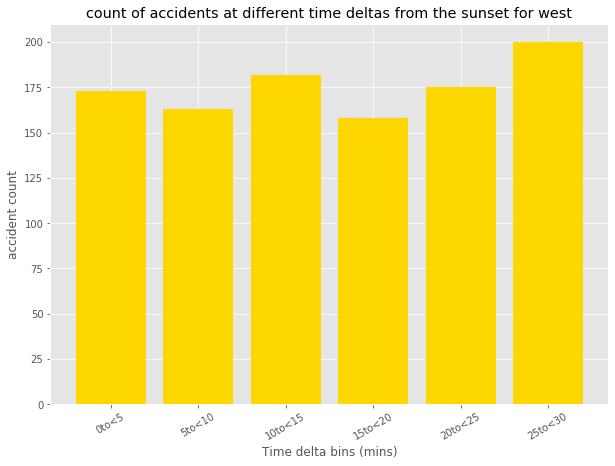

In [44]:
time_delta_bins = list(accidents_sunset_group_bins_df)
count_each_bin_e = list(accidents_sunset_group_bins_df.iloc[0])
count_each_bin_n = list(accidents_sunset_group_bins_df.iloc[1])
count_each_bin_s = list(accidents_sunset_group_bins_df.iloc[2])
count_each_bin_w = list(accidents_sunset_group_bins_df.iloc[3])
direction = 'west'
plot_bar(time_delta_bins, count_each_bin_w, 'gold', direction)
os.makedirs(os.path.join('output_data'),exist_ok=True)
plt.savefig(os.path.join('output_data',f'accident_count_vs_time_delta_bins_{direction}.png'))

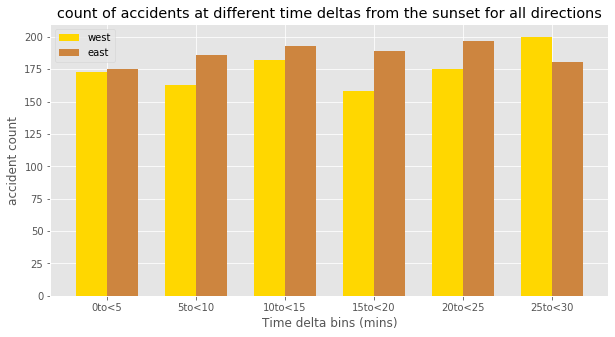

In [45]:
N = 6 #number of bins
ind = np.arange(N) 
width = 0.35 
# Figure size
plt.figure(figsize=(10,5))
plt.bar(ind, count_each_bin_w, width, label='west', color='gold')
plt.bar(ind + width, count_each_bin_e,width,
    label='east', color='#CD853F')

plt.ylabel("accident count")
plt.title('count of accidents at different time deltas from the sunset for all directions')
plt.xlabel("Time delta bins (mins)")
plt.xticks(ind + width / 2, (time_delta_bins))
plt.legend(loc='best')
plt.savefig(os.path.join('output_data',f'accident_count_vs_time_delta_bins_west_east.png'))

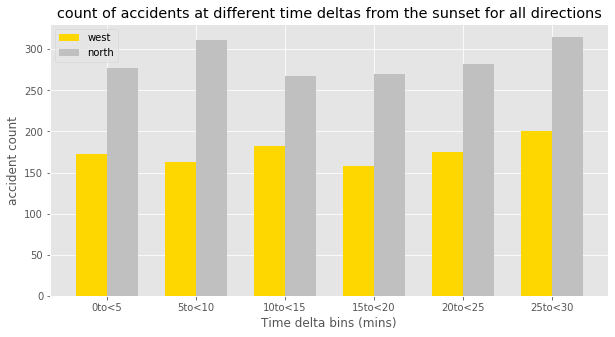

In [46]:
N = 6 #number of bins
ind = np.arange(N) 
width = 0.35 
# Figure size
plt.figure(figsize=(10,5))
plt.bar(ind, count_each_bin_w, width, label='west', color='gold')
plt.bar(ind + width, count_each_bin_n, width,
    label='north', color='silver')
plt.xlabel("Time delta bins (mins)")
plt.ylabel("accident count")
plt.title('count of accidents at different time deltas from the sunset for all directions')

plt.xticks(ind + width / 2, (time_delta_bins))
plt.legend(loc='best')
plt.savefig(os.path.join('output_data',f'accident_count_vs_time_delta_bins_west_north.png'))

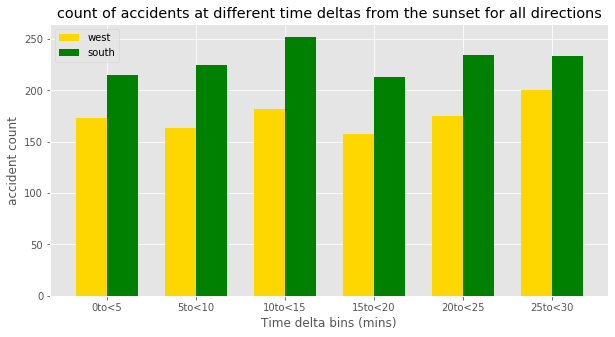

In [47]:
N = 6 #number of bins
ind = np.arange(N) 
width = 0.35 
# Figure size
plt.figure(figsize=(10,5))
plt.bar(ind, count_each_bin_w, width, label='west', color='gold')
plt.bar(ind + width, count_each_bin_s, width,
    label='south', color='green')
plt.xlabel("Time delta bins (mins)")
plt.ylabel("accident count")
plt.title('count of accidents at different time deltas from the sunset for all directions')

plt.xticks(ind + width / 2, (time_delta_bins))
plt.legend(loc='best')
plt.savefig(os.path.join('output_data',f'accident_count_vs_time_delta_bins_west_south.png'))

In [49]:
# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(count_each_bin_w, count_each_bin_e, equal_var=False)

Ttest_indResult(statistic=-1.6888320422868357, pvalue=0.13137067461053104)

In [50]:
# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(count_each_bin_w, count_each_bin_n, equal_var=False)

Ttest_indResult(statistic=-10.687477848358125, pvalue=1.9593539737329165e-06)

In [51]:
# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(count_each_bin_w, count_each_bin_s, equal_var=False)

Ttest_indResult(statistic=-6.322377490627258, pvalue=8.699406328705758e-05)